In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas import MultiIndex, Int16Dtype
import xgboost as xgb
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

In [50]:
#Load Data
X1 = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\X1.csv",parse_dates=['date'])
X2 = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\X2.csv")
y = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\y.csv",parse_dates=['date'])

In [51]:
X2 = X2[['id', 'family', 'store_nbr', 'moving_avg_oil', 'onpromotion', 'dayofweek', 'transactions']]

In [52]:
X1['NewYear'] = X1['NewYear'].astype('bool').astype('int')

In [53]:
#Format
index = ['store_nbr', 'family', 'date']
X2 = X2.set_index('id')
X1 = X1.set_index('date').to_period('D')
y_multi = y.set_index(index).sort_index()
y_wide = y_multi.unstack(level=[0, -2])
y = y.set_index('date').to_period('D')

In [54]:
#Split Forecasting Data
X1_holdout = X1['2017-08-16':].copy()
X2_holdout = X2[3000888:].copy()
X1 = X1['2017':'2017-08-15']
X2 = X2[2596374:3000888]
y_wide = y_wide['2017':]
#Split Train_Test Data
X1_train, X1_test, y1_train, y_test = train_test_split(X1, y_wide, test_size=0.15, shuffle=False, stratify=None)
X2_split_index = (X1_train.shape[0] * 1782)
X2_train = X2[:X2_split_index]
X2_test = X2[X2_split_index:]

In [55]:
class HybridPipeline:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

In [56]:
def fit(self, X1, X2, y):
    self.model_1.fit(X1, y)
    
    y_fit = pd.DataFrame(
    self.model_1.predict(X1),
    index=X1.index,
    columns = y.columns)
    
    #compuing residuals  
    y_fit = y_fit.stack(['store_nbr','family']).reset_index().drop(columns=['store_nbr','family','date']).rename(columns={'sales':'y_fit'})
    g = y1_train.stack(['store_nbr','family']).reset_index()
    df_resid = pd.concat([y_fit,g],axis=1)
    df_resid['y_resid'] = df_resid['sales']-df_resid['y_fit']
    df_resid = df_resid.set_index('date')
    y1_resid = df_resid['y_resid']
    
   # self.model_2.fit(X2,
   #                  y1_resid,
   #                  verbose=True,
   #                  eval_metric='auc') 
                     #early_stopping_rounds=10, eval_set = [(X2_test, y_test)] #Evaluating how many trees to build based on testing dataset
    return df_resid['y_fit'], df_resid['y_resid']
    
HybridPipeline.fit = fit

In [57]:
def predict(self, X1, X2, y):    
    y_pred = pd.DataFrame(
    self.model_1.predict(X1),
    index = X1.index,
    columns = y.columns)
    
    y_pred1 = y_pred.stack(['store_nbr','family']).reset_index().drop(columns=['store_nbr','family','date'])
    y_pred2 = self.model_2.predict(X2)
    y_pred2_df =  pd.DataFrame(y_pred2)
    preds = pd.concat([y_pred2_df,y_pred1], axis=1).rename(columns={0:'y_pred2','sales':'y_pred1'})
    preds['y_pred'] = preds['y_pred1'] + preds['y_pred2']  
    
    return preds

HybridPipeline.predict = predict #adding predict method to class

In [58]:
model = HybridPipeline(
    model_1 = LinearRegression(fit_intercept=False),
    model_2 = XGBRegressor()) #n_estimators=100, learning_rate=0.1

In [59]:
y1_fit, y1_resid = model.fit(X1_train, X2_train, y1_train)

In [60]:
model.model_2.fit(X2_train,y1_resid,
                  verbose=True,
                  eval_metric='auc')

C:\Users\adeli\ProgramData\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [61]:
preds = model.predict(X1_test, X2_test, y1_train) #y_train passed for columns names
y_preds_df = preds[['y_pred']]

In [62]:
X1_holdout.shape, X2_holdout.shape

((16, 27), (28512, 6))

In [63]:
y_preds_sub = model.predict(X1_holdout, X2_holdout, y1_train) #y_train passed for columns names

In [64]:
def rmsle(predicted, actual):
    n = len(predicted)
    E = []
    i = 0
    for i in range(n):
        left = np.log(predicted[i]+1)
        right = np.log(actual[i]+1)
        E.append((left-right)**2)
    return sqrt((sum(E)/2))

In [65]:
#preds['y_pred2'].shape
y1_resid.shape

(342144,)

In [66]:
y_test_long = y_test.stack(['store_nbr','family']).reset_index().drop(columns=index)

In [67]:
rmsle(preds['y_pred2'], y_test_long['sales'])
#y_preds['y_pred'][33]

C:\Users\adeli\AppData\Local\Temp\ipykernel_11120\665262965.py:6: RuntimeWarning: invalid value encountered in log
  left = np.log(predicted[i]+1)


nan

In [68]:
y_test_multi = y_test.stack(['store_nbr','family']).reset_index()
preds_multi = pd.concat([y_test_multi, y_preds_df],axis=1).set_index('date')

In [69]:
#Transformations into daily average sales
y_preds = preds_multi[['y_pred']].groupby('date').mean().squeeze()
y_actual = preds_multi[['sales']].groupby('date').mean().squeeze()
y1_train_avg = y1_train.stack(['store_nbr','family']).reset_index().drop(columns=['store_nbr','family']).set_index('date').groupby('date').mean().squeeze()
y1_fit_avg = y1_fit.groupby('date').mean().squeeze()
y1_resid_avg = y1_resid.groupby('date').mean().squeeze()
preds_df = pd.concat([y1_train_avg,y1_fit_avg,y1_resid_avg,y_preds],axis=1).rename(columns={'sales':'y_training'})
preds = pd.concat([preds_df, y_actual]).rename(columns={0:'y_test'})

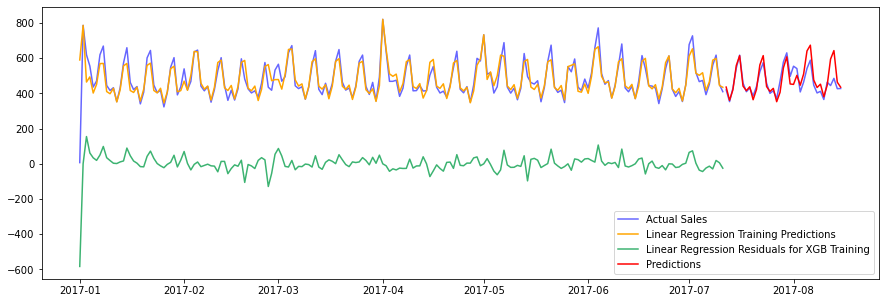

In [70]:
f1 = plt.figure()
#Training
plt.plot(preds['y_training'], color='blue', alpha=0.6, label='Actual Sales')
plt.plot(preds['y_fit'], color='orange', label='Linear Regression Training Predictions')
plt.plot(preds['y_resid'], color='mediumseagreen', label='Linear Regression Residuals for XGB Training')
#Testing
plt.plot(preds['y_test'], color='blue', alpha=0.6)
plt.plot(preds['y_pred'], color='red', label='Predictions')
f1.set_figwidth(15)
f1.set_figheight(5)
plt.legend()
plt.show()

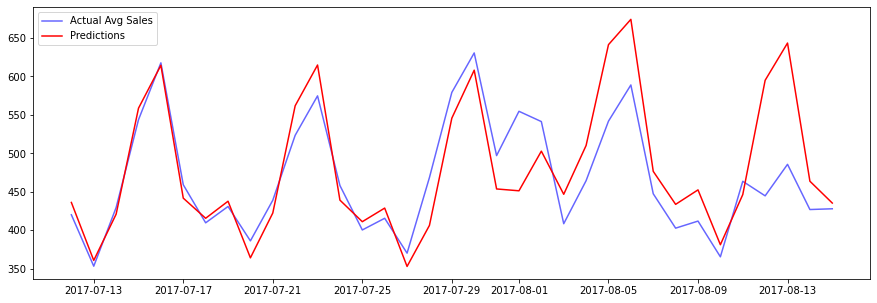

In [71]:
f2 = plt.figure()
plt.plot(preds['y_test'], color='blue', alpha=0.6, label='Actual Avg Sales')
plt.plot(preds['y_pred'], color='red', label='Predictions')
f2.set_figwidth(15)
f2.set_figheight(5)
plt.legend()

In [72]:
sample_sub = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\sample_submission.csv")
submission = pd.concat([y_preds_sub['y_pred'],sample_sub],axis=1).set_index('id').drop(columns=['sales']).rename(columns={'y_pred':'sales'})
submission.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\submission_4.csv")

In [73]:
submission

,sales
id,
3000888,25.741736
3000889,21.613821
3000890,17.418762
3000891,-52.503332
3000892,-174.118431
...,...
3029395,5.825383
3029396,-41.052927
3029397,-1333.475627


In [91]:
model.model_2

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [74]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

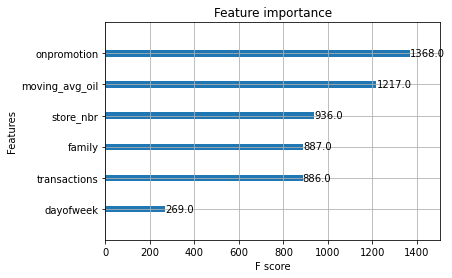

In [75]:
plot_importance(model.model_2)